<a href="https://colab.research.google.com/github/pizzapasit/Tacotron_Training_jane102/blob/main/Tacotron_Training_jane102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tacotron Training Notebook **(WIP)**

Last edit: April 8th, 2022, 17:10:42 PM

This is the Notebook for training new Tacotron models.



In [ ]:
!pip install --upgrade gdown

# Check GPU


In [ ]:
import os
os.chdir("/content")
!pwd
!nvidia-smi -L

/content
GPU 0: Tesla T4 (UUID: GPU-2d8f4033-c02a-5718-e1ec-73eb8d9f8663)


#Mount Your Google Drive



In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Donwload Tacotron

In [ ]:
%tensorflow_version 1.x
import os
!git clone -q https://github.com/NVIDIA/tacotron2
os.chdir('tacotron2')
!git submodule init
!git submodule update
!pip install -q unidecode tensorboardX

TensorFlow 1.x selected.
fatal: destination path 'tacotron2' already exists and is not an empty directory.


# Upload dataset


In [ ]:
# UPLOAD AUDIO FILES TO 'wavs'
data_path = 'wavs'
!mkdir {data_path}

mkdir: cannot create directory ‘wavs’: File exists


# Prepare the model


In [ ]:
#@title 
%matplotlib inline
import os
if os.getcwd() != '/content/tacotron2':
    os.chdir('tacotron2')

import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams
 
import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename, 
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    print(checkpoint_path)
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)
    

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      if not os.path.isfile("pretrained_model"):
      # download_from_google_drive("1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA","pretrained_model")
        !gdown --id 1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
        !mv 'tacotron2_statedict.pt' 'pretrained_model'
      model = warm_start_model("pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists
    
    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
# ---- Replace .wav with .npy in filelists ----

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
#@title 

model_filename = "MODEL_TEST_Tacotron" #@param {type:"string"}

In [ ]:
# THE metadata.txt/metadata.csv MAP FILE
hparams.training_files = "filelists/train_janeyre_tacotron_filelist.txt"
hparams.validation_files = "filelists/test_janeyre_tacotron_filelist.txt"

### Set the parameters


In [ ]:

hparams.batch_size = 10
hparams.epochs = 50 


hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000        
hparams.A_ = 5e-4                   # Start/Max Learning Rate
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate
generate_mels = True # Don't change
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.load_mel_from_disk = True
hparams.ignore_layers = []

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/tacotron2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

### Create MEL spectrograms


In [ ]:
if generate_mels:
    create_mels()

Generating Mels


  0%|          | 0/105 [00:00<?, ?it/s]

/content/tacotron2/utils.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = read(full_path)


### Check data


In [ ]:
check_dataset(hparams)

Checking Training Files
Checking Validation Files
Finished Checking


# Start training!

In [ ]:
torch.cuda.empty_cache()

/content/tacotron2
FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
pretrained_model
Warm starting model from checkpoint 'pretrained_model'


  0%|          | 0/50 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 Validation loss 5:  2.118008  Time: 0.4m LR: 0.000500


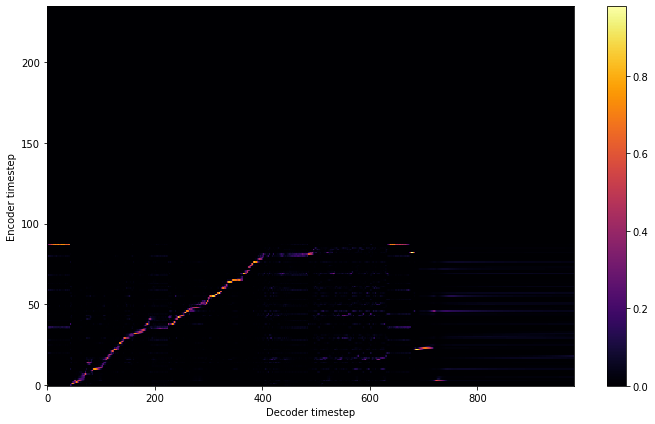

Saving model and optimizer state at iteration 5 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 1 Iteration: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 Validation loss 10:  0.593657  Time: 0.4m LR: 0.000500


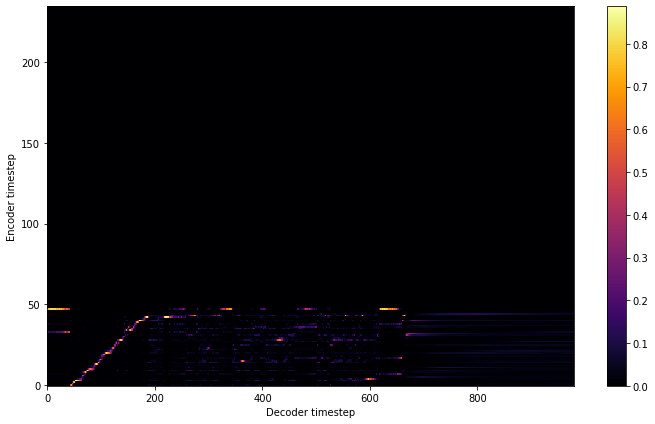

Saving model and optimizer state at iteration 10 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 2 Iteration: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 Validation loss 15:  0.503379  Time: 0.4m LR: 0.000500


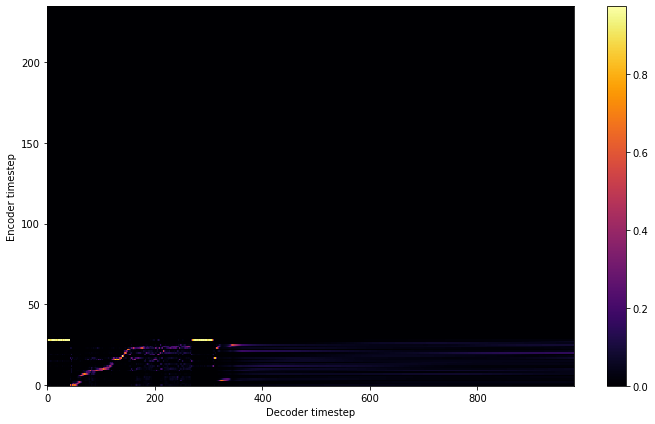

Saving model and optimizer state at iteration 15 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 3 Iteration: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 Validation loss 20:  0.475227  Time: 0.4m LR: 0.000500


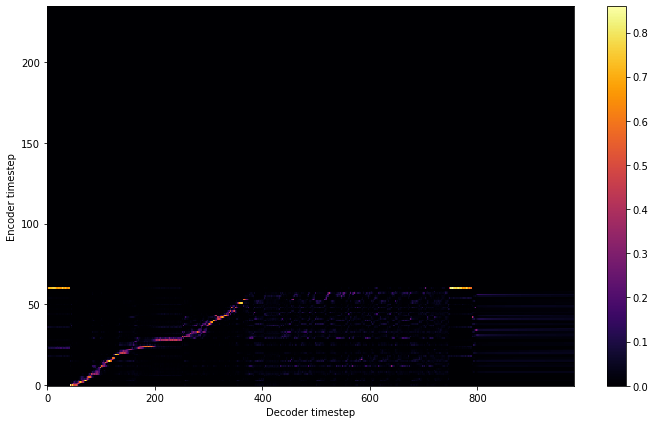

Saving model and optimizer state at iteration 20 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 4 Iteration: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 Validation loss 25:  0.476941  Time: 0.4m LR: 0.000500


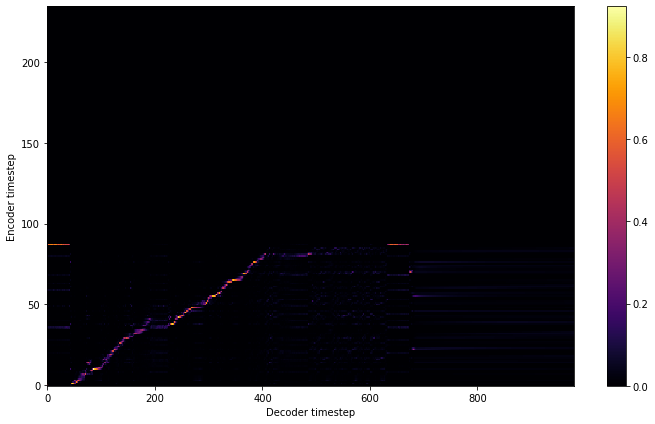

Saving model and optimizer state at iteration 25 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 5 Iteration: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 Validation loss 30:  0.481980  Time: 0.4m LR: 0.000500


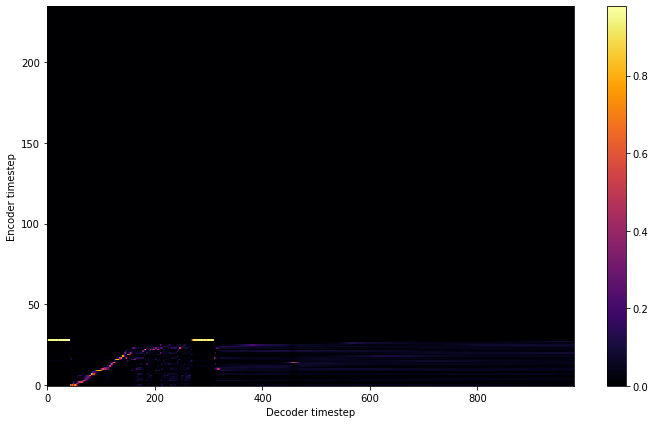

Saving model and optimizer state at iteration 30 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 6 Iteration: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 Validation loss 35:  0.466372  Time: 0.4m LR: 0.000500


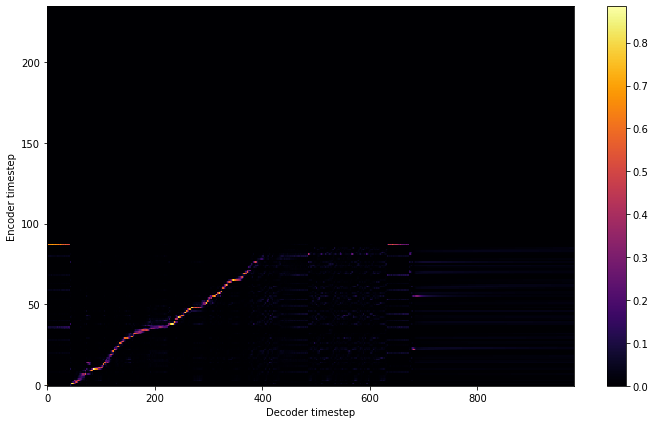

Saving model and optimizer state at iteration 35 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 7 Iteration: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 Validation loss 40:  0.436018  Time: 0.4m LR: 0.000500


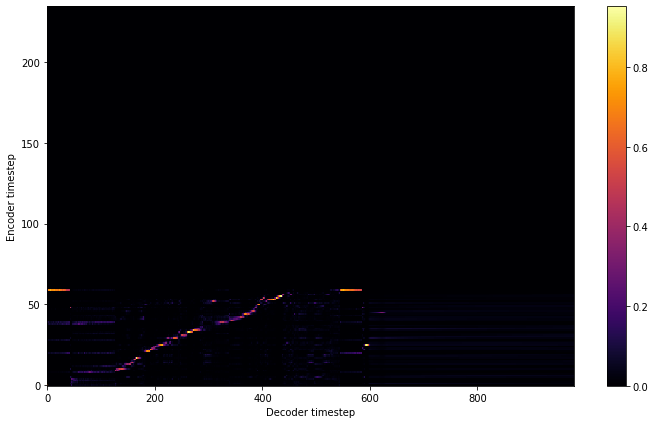

Saving model and optimizer state at iteration 40 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 8 Iteration: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 Validation loss 45:  0.416582  Time: 0.4m LR: 0.000500


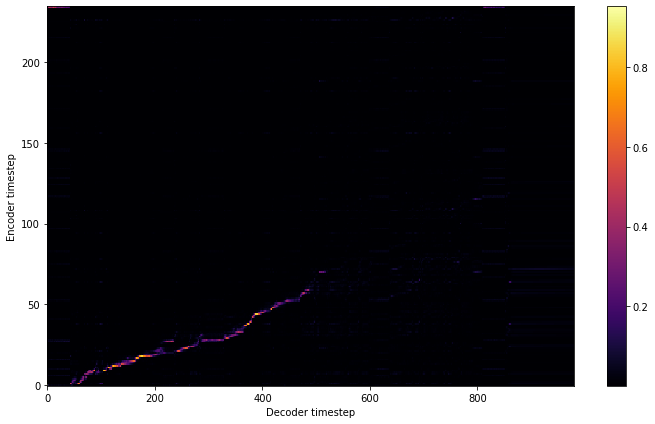

Saving model and optimizer state at iteration 45 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 9 Iteration: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 Validation loss 50:  0.400930  Time: 0.4m LR: 0.000500


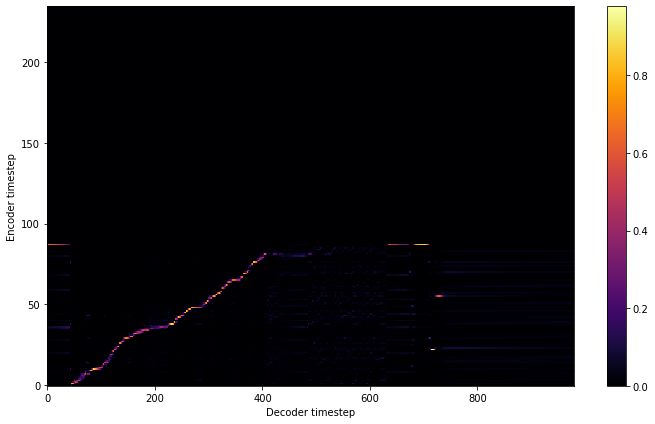

Saving model and optimizer state at iteration 50 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 10 Iteration: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 Validation loss 55:  0.381576  Time: 0.4m LR: 0.000500


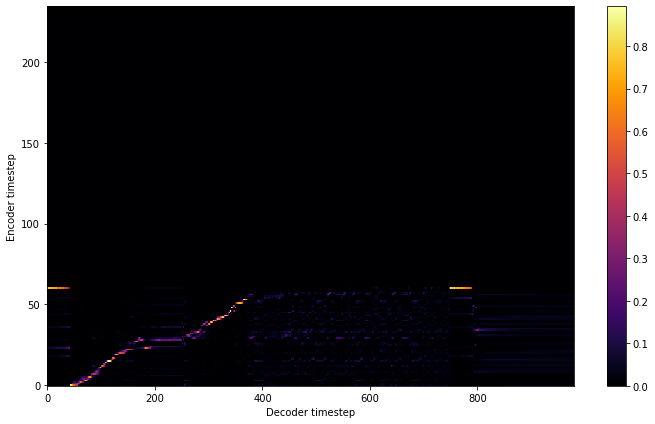

Saving model and optimizer state at iteration 55 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 11 Iteration: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 Validation loss 60:  0.365004  Time: 0.4m LR: 0.000500


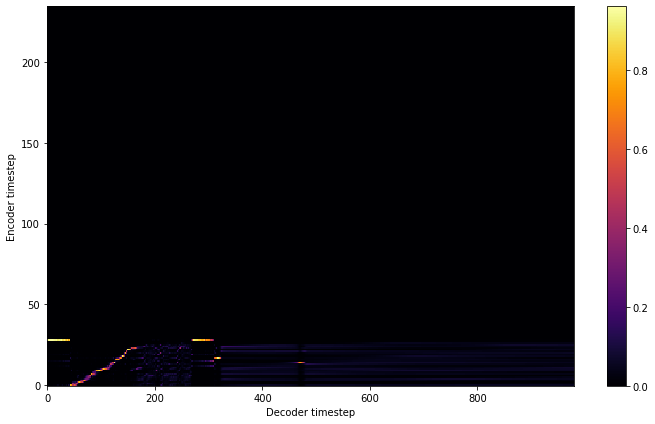

Saving model and optimizer state at iteration 60 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 12 Iteration: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 Validation loss 65:  0.387356  Time: 0.4m LR: 0.000500


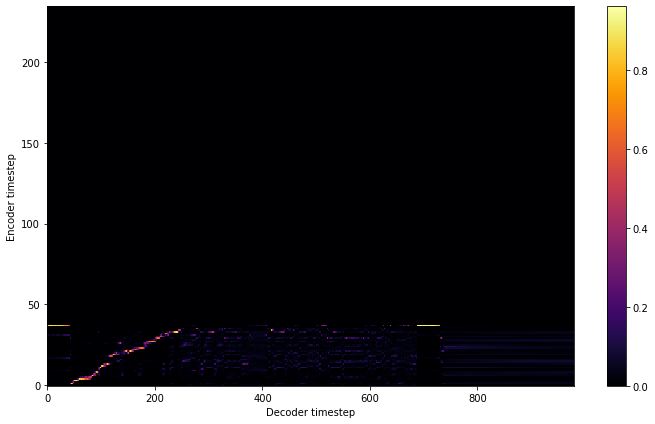

Saving model and optimizer state at iteration 65 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 13 Iteration: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 Validation loss 70:  0.357790  Time: 0.4m LR: 0.000500


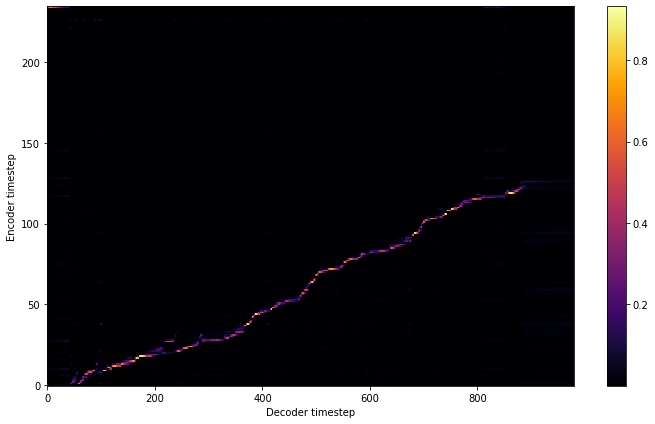

Saving model and optimizer state at iteration 70 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 14 Iteration: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 Validation loss 75:  0.352594  Time: 0.4m LR: 0.000500


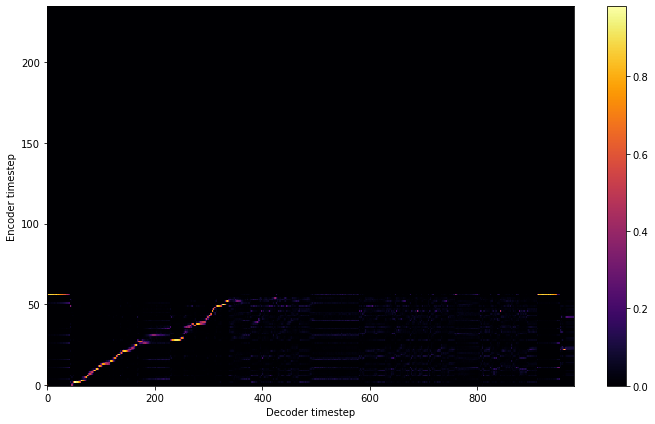

Saving model and optimizer state at iteration 75 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 15 Iteration: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 Validation loss 80:  0.353167  Time: 0.4m LR: 0.000500


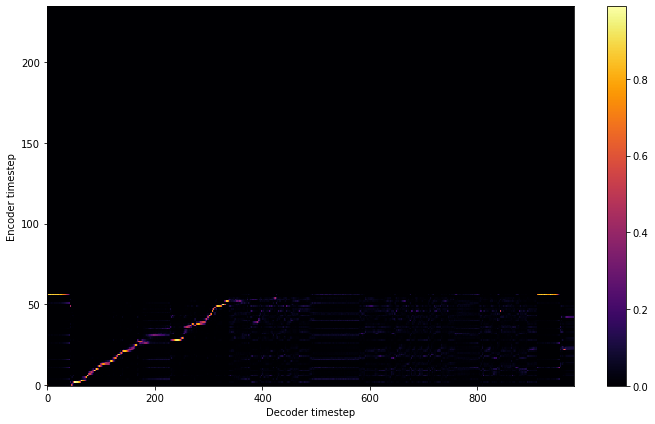

Saving model and optimizer state at iteration 80 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 16 Iteration: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 Validation loss 85:  0.362804  Time: 0.4m LR: 0.000500


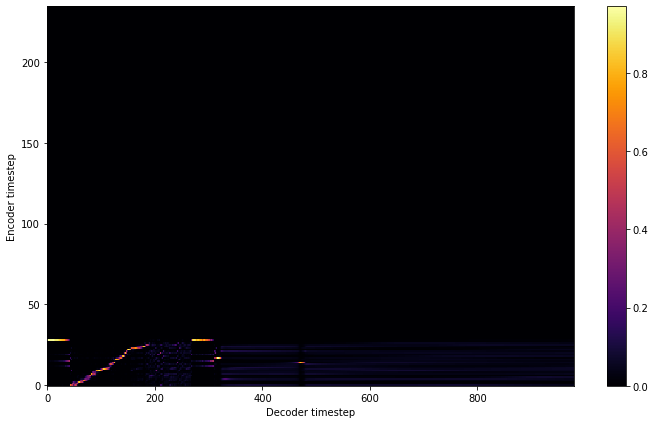

Saving model and optimizer state at iteration 85 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 17 Iteration: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 Validation loss 90:  0.362863  Time: 0.4m LR: 0.000500


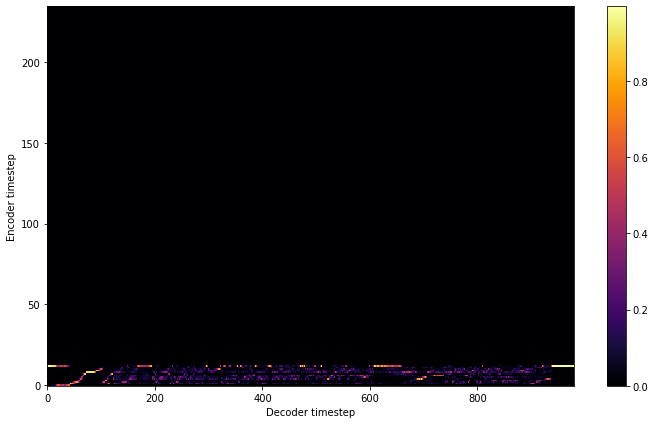

Saving model and optimizer state at iteration 90 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 18 Iteration: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 Validation loss 95:  0.349674  Time: 0.4m LR: 0.000500


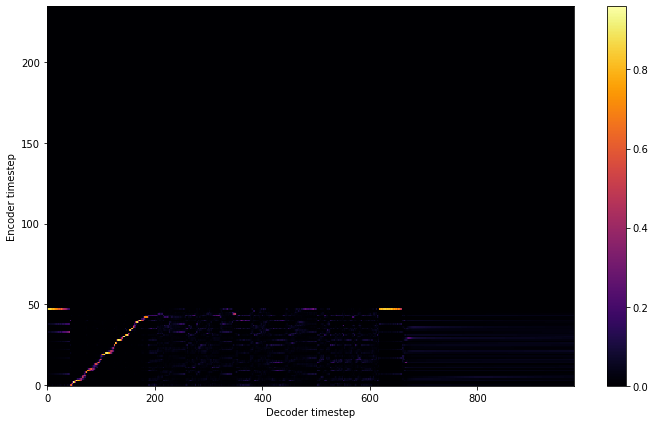

Saving model and optimizer state at iteration 95 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 19 Iteration: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 Validation loss 100:  0.346871  Time: 0.4m LR: 0.000500


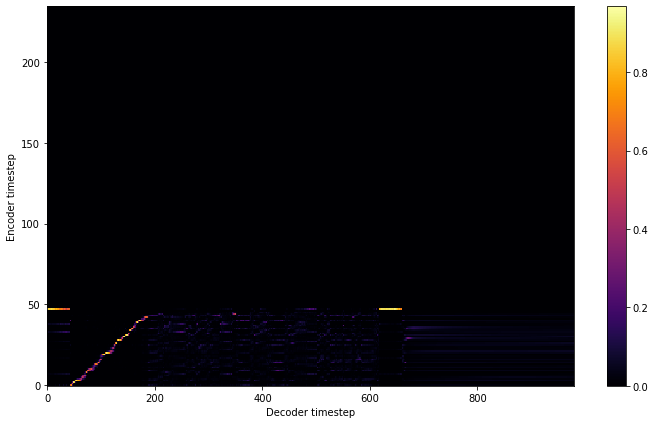

Saving model and optimizer state at iteration 100 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 20 Iteration: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 Validation loss 105:  0.355390  Time: 0.4m LR: 0.000500


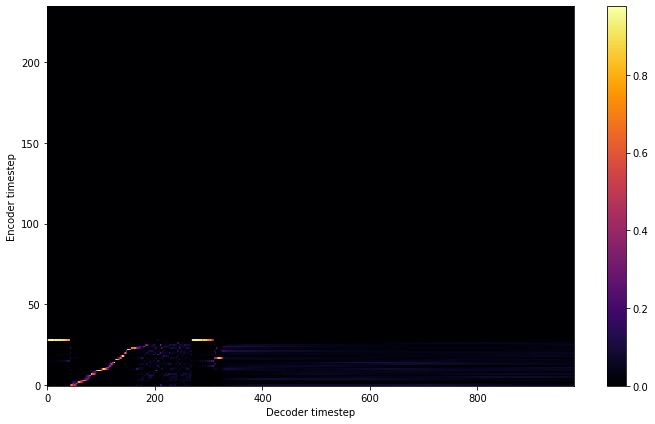

Saving model and optimizer state at iteration 105 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 21 Iteration: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21 Validation loss 110:  0.353808  Time: 0.4m LR: 0.000500


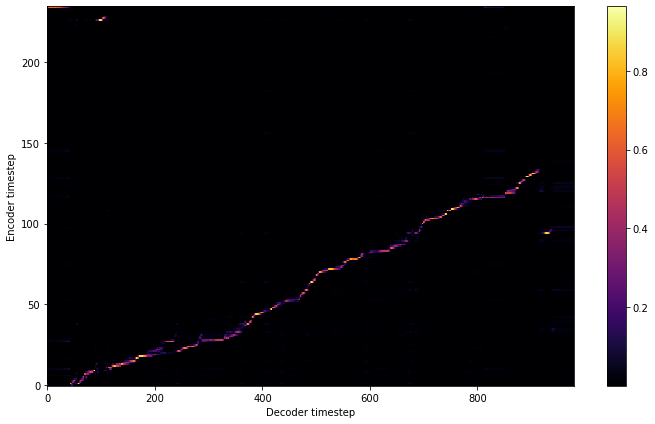

Saving model and optimizer state at iteration 110 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 22 Iteration: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 22 Validation loss 115:  0.348196  Time: 0.4m LR: 0.000500


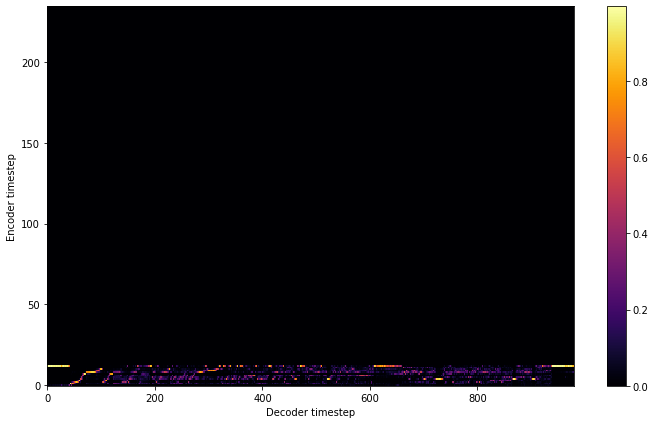

Saving model and optimizer state at iteration 115 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 23 Iteration: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23 Validation loss 120:  0.353627  Time: 0.4m LR: 0.000500


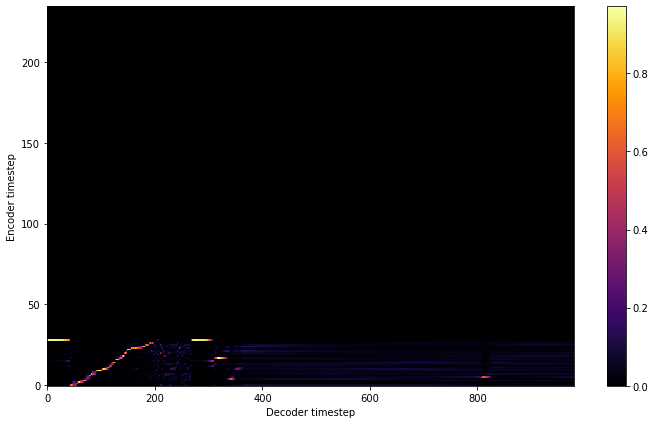

Saving model and optimizer state at iteration 120 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 24 Iteration: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24 Validation loss 125:  0.357930  Time: 0.4m LR: 0.000500


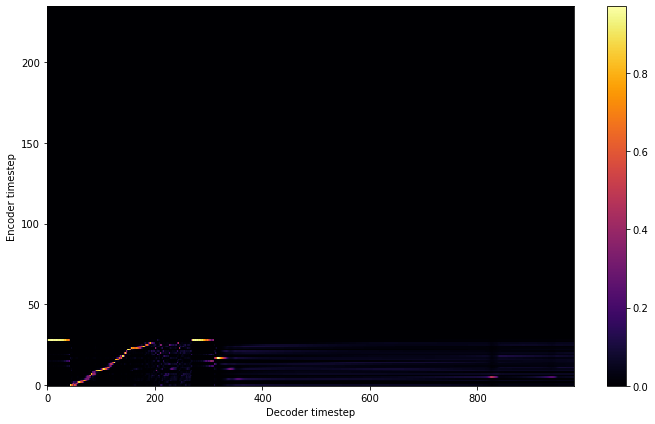

Saving model and optimizer state at iteration 125 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 25 Iteration: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25 Validation loss 130:  0.352224  Time: 0.4m LR: 0.000500


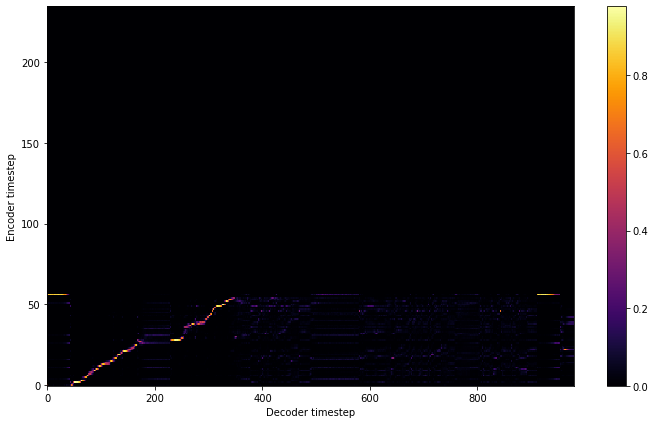

Saving model and optimizer state at iteration 130 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 26 Iteration: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 Validation loss 135:  0.358516  Time: 0.4m LR: 0.000500


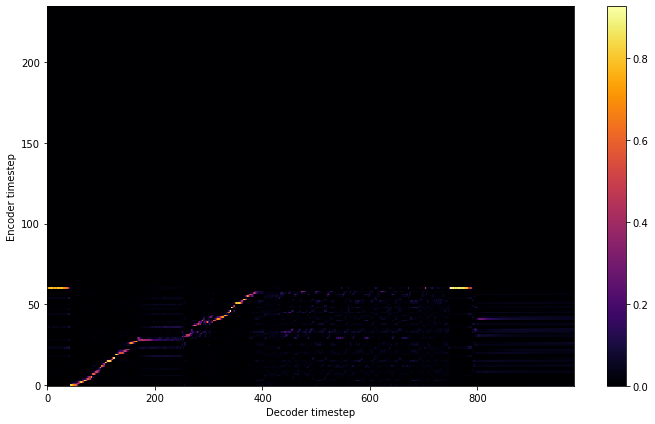

Saving model and optimizer state at iteration 135 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 27 Iteration: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27 Validation loss 140:  0.353061  Time: 0.4m LR: 0.000500


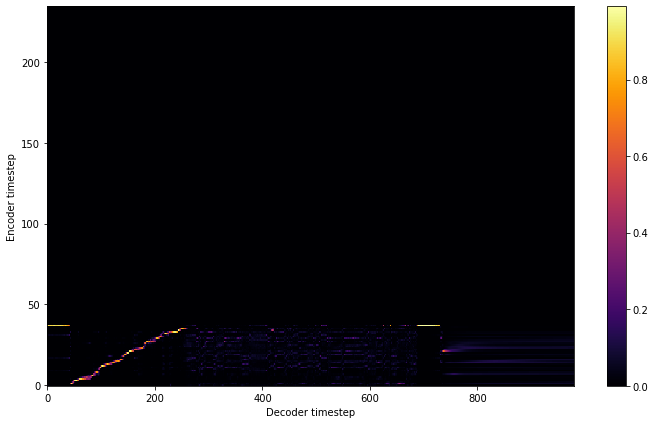

Saving model and optimizer state at iteration 140 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 28 Iteration: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28 Validation loss 145:  0.358932  Time: 0.4m LR: 0.000500


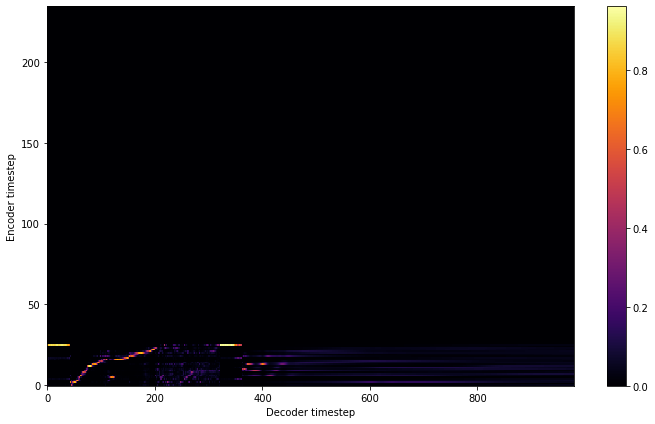

Saving model and optimizer state at iteration 145 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 29 Iteration: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29 Validation loss 150:  0.360603  Time: 0.4m LR: 0.000500


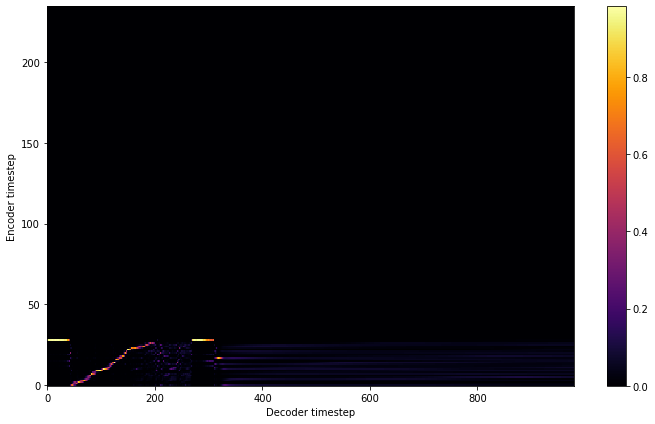

Saving model and optimizer state at iteration 150 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 30 Iteration: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30 Validation loss 155:  0.364734  Time: 0.4m LR: 0.000500


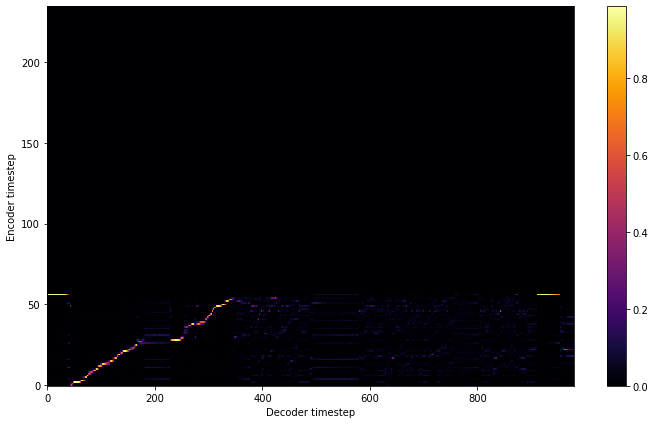

Saving model and optimizer state at iteration 155 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 31 Iteration: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 31 Validation loss 160:  0.364796  Time: 0.4m LR: 0.000500


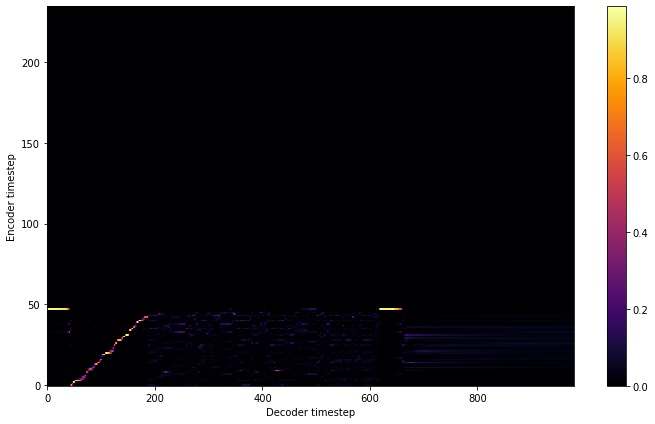

Saving model and optimizer state at iteration 160 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 32 Iteration: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 32 Validation loss 165:  0.367297  Time: 0.4m LR: 0.000500


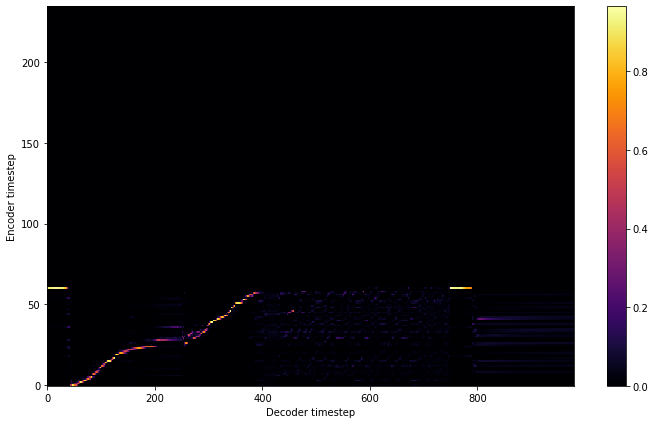

Saving model and optimizer state at iteration 165 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 33 Iteration: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 33 Validation loss 170:  0.369997  Time: 0.4m LR: 0.000500


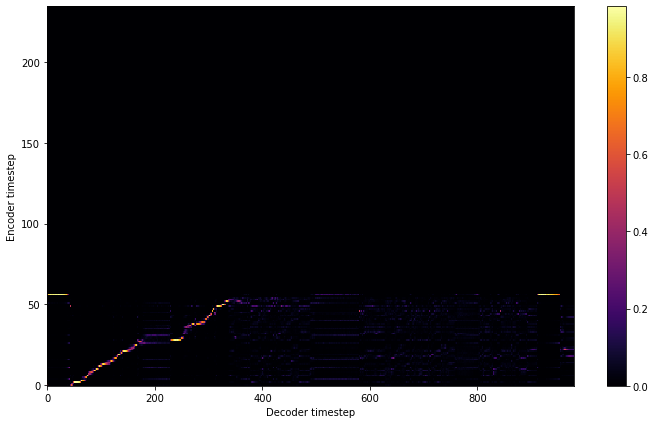

Saving model and optimizer state at iteration 170 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 34 Iteration: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 34 Validation loss 175:  0.363539  Time: 0.4m LR: 0.000500


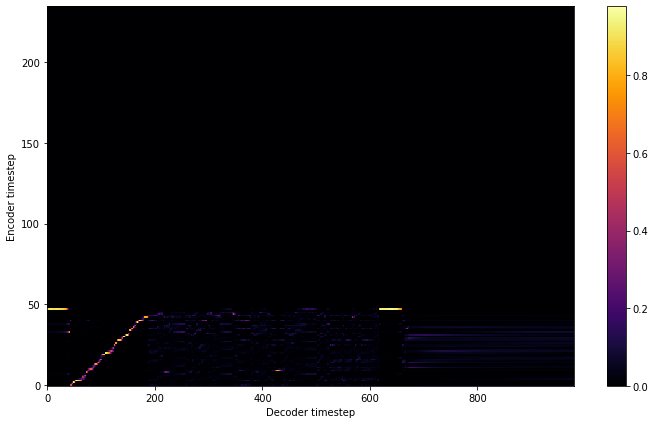

Saving model and optimizer state at iteration 175 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 35 Iteration: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 35 Validation loss 180:  0.374945  Time: 0.4m LR: 0.000500


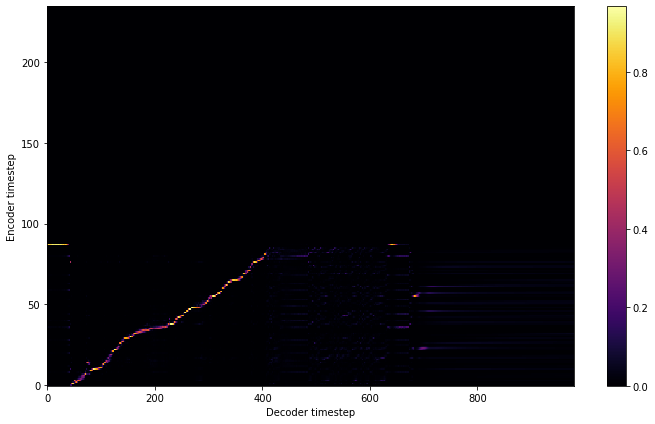

Saving model and optimizer state at iteration 180 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 36 Iteration: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 36 Validation loss 185:  0.364299  Time: 0.4m LR: 0.000500


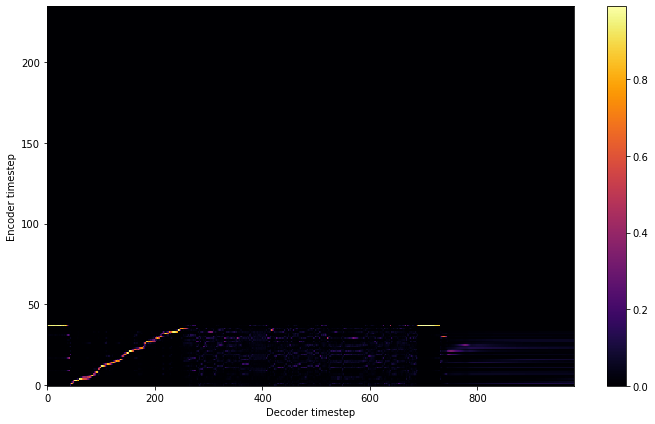

Saving model and optimizer state at iteration 185 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 37 Iteration: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 37 Validation loss 190:  0.377394  Time: 0.4m LR: 0.000500


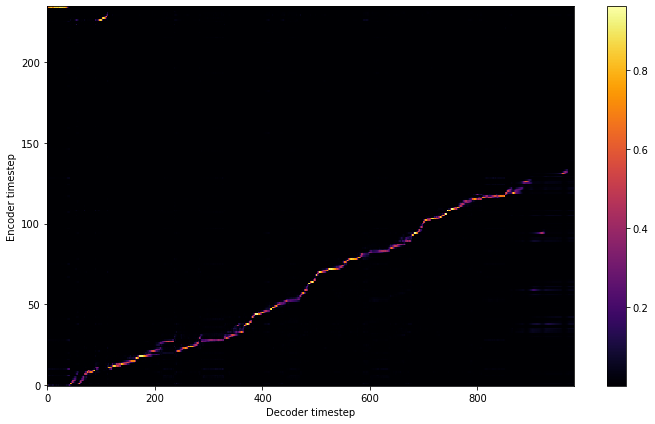

Saving model and optimizer state at iteration 190 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 38 Iteration: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 38 Validation loss 195:  0.385683  Time: 0.4m LR: 0.000500


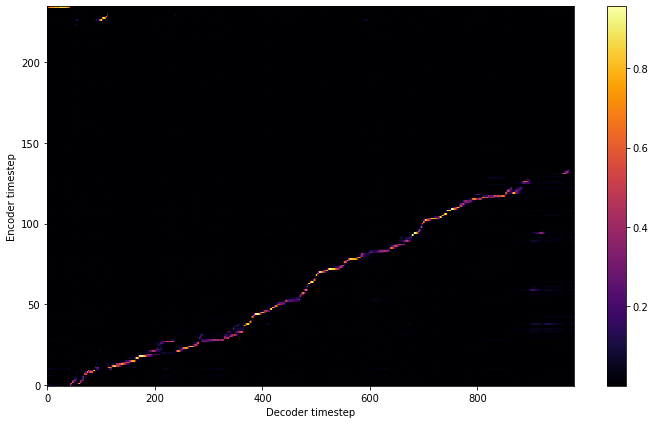

Saving model and optimizer state at iteration 195 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 39 Iteration: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 39 Validation loss 200:  0.374013  Time: 0.4m LR: 0.000500


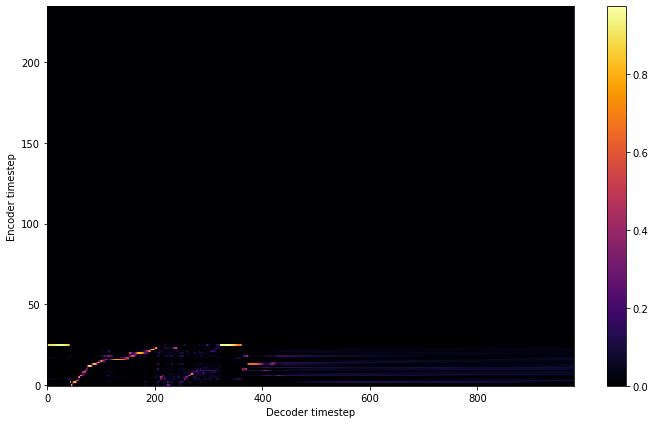

Saving model and optimizer state at iteration 200 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 40 Iteration: 200


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 40 Validation loss 205:  0.375928  Time: 0.4m LR: 0.000500


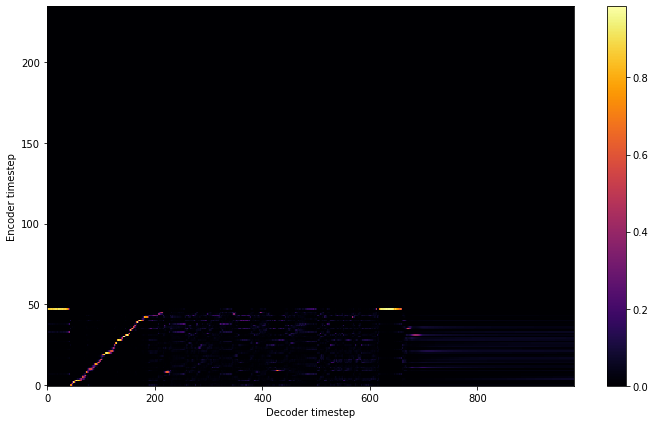

Saving model and optimizer state at iteration 205 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 41 Iteration: 205


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 41 Validation loss 210:  0.392041  Time: 0.4m LR: 0.000500


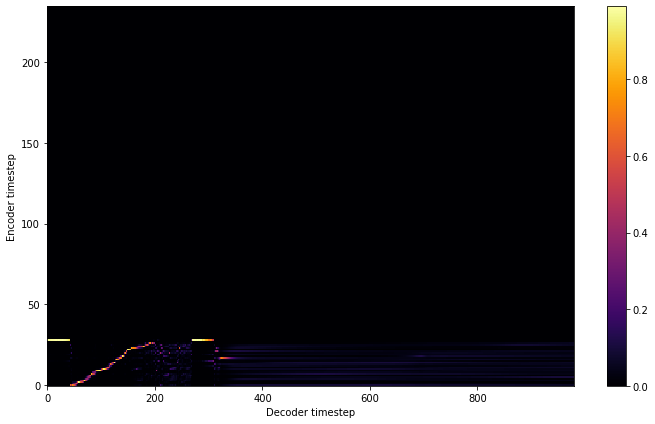

Saving model and optimizer state at iteration 210 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 42 Iteration: 210


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 42 Validation loss 215:  0.375467  Time: 0.4m LR: 0.000500


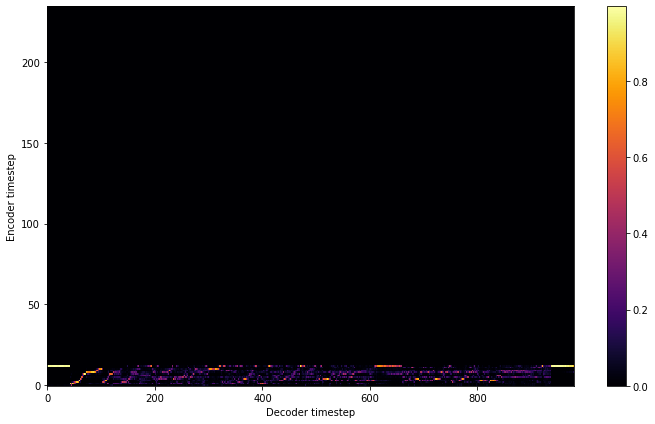

Saving model and optimizer state at iteration 215 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 43 Iteration: 215


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 43 Validation loss 220:  0.377764  Time: 0.4m LR: 0.000500


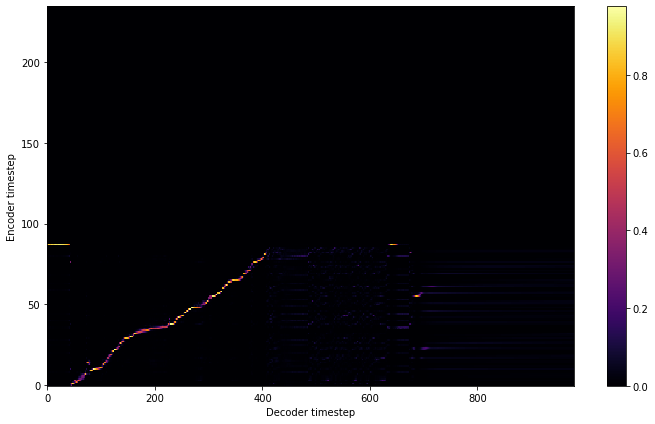

Saving model and optimizer state at iteration 220 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 44 Iteration: 220


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 44 Validation loss 225:  0.374295  Time: 0.4m LR: 0.000500


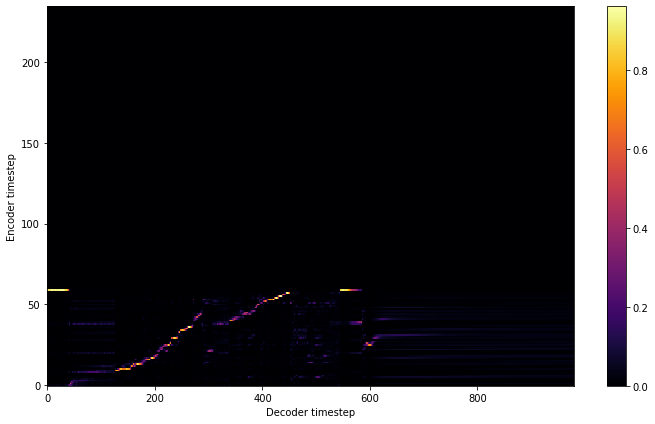

Saving model and optimizer state at iteration 225 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 45 Iteration: 225


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 45 Validation loss 230:  0.381956  Time: 0.4m LR: 0.000500


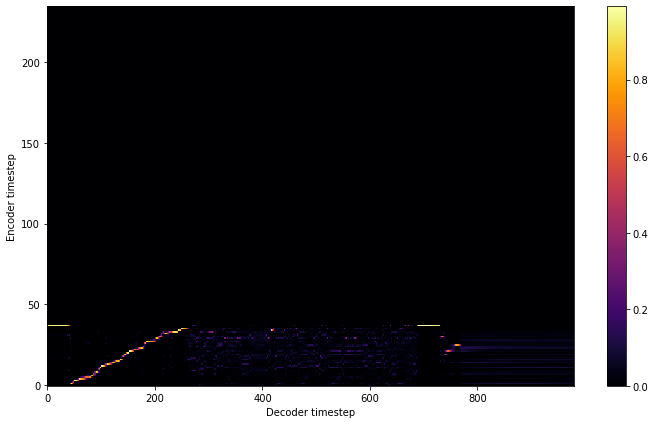

Saving model and optimizer state at iteration 230 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 46 Iteration: 230


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 46 Validation loss 235:  0.377653  Time: 0.4m LR: 0.000500


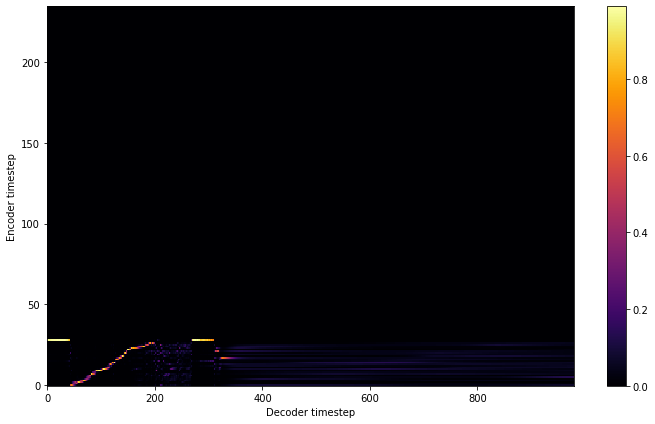

Saving model and optimizer state at iteration 235 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 47 Iteration: 235


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 47 Validation loss 240:  0.379797  Time: 0.4m LR: 0.000500


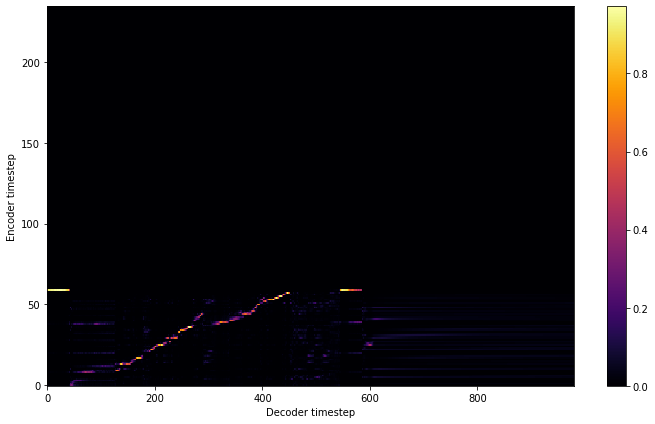

Saving model and optimizer state at iteration 240 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 48 Iteration: 240


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 48 Validation loss 245:  0.379772  Time: 0.4m LR: 0.000500


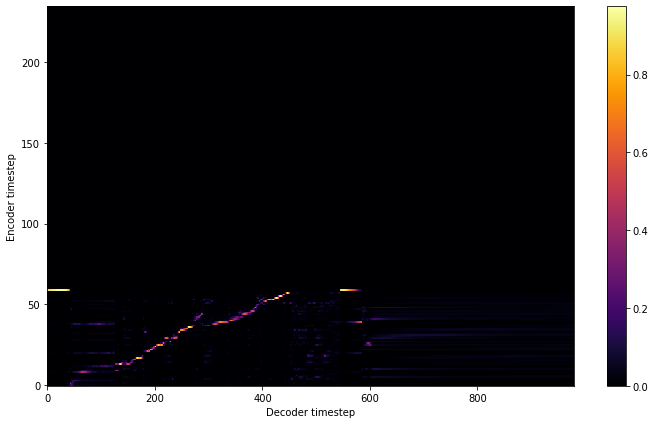

Saving model and optimizer state at iteration 245 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved

Starting Epoch: 49 Iteration: 245


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 49 Validation loss 250:  0.382807  Time: 0.4m LR: 0.000500


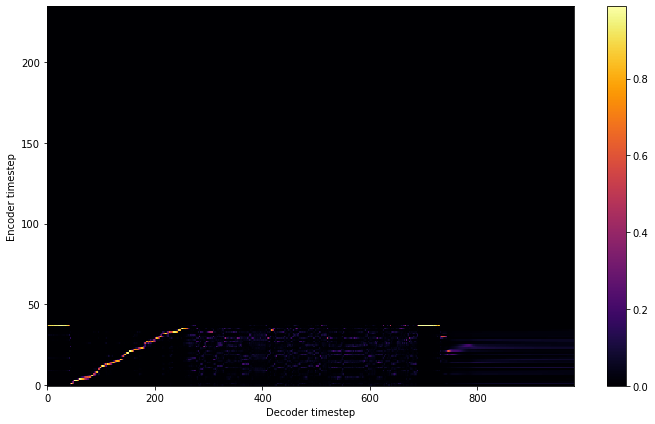

Saving model and optimizer state at iteration 250 to /content/drive/My Drive/colab/outdir/MODEL_TEST_Tacotron
Model Saved


In [ ]:
!pwd
print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2)